In [1]:
# Usado para ler arquivos, carregar código personalizado e ter acesso a outros recursos de sistema
import os
import sys

# Programação funcional e utilitários
import funcy as fp
import itertools

# Recursos para texto
import re

# Verificação de tipos
from typing import List

# Manipulação e análise dos dados
import numpy as np
import pandas as pd

# Manipulação e análise de texto
import fasttext

# Redução de Dimensionalidade e Análise de Similaridade
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from scipy.special import softmax

# Recursos para visualização dos dados
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import HTML, display

# Carregar, além de atualizar frequentemente, código personalizado disponível em ../src
%load_ext autoreload 
%autoreload 2
sys.path.append(os.path.abspath(os.path.pardir))
from src import settings
from src.utils.notebooks import display_side_by_side
from src.utils.experiments import set_dataset_split, extract_tokens, TAG_SPLIT_PATTERN
from src.utils.experiments import compute_multiclass_classification_metrics

# Configurações para a exibição de conteúdo do Pandas e das bibliotecas gráficas
%matplotlib inline 
sns.set(rc={'figure.figsize':(25,10)})
pd.set_option('display.max_rows', None)
pd.set_option("display.max_columns", None)
pd.set_option('max_colwidth', 150)

# Importante: Este notebook está em estágio inicial de desenvolvimento

TODO (ou devaneios):
 - Verificar tamanho do vocabulário usando TF-IDF 
 - Fazer avaliações de similaridade e busca usando as abordagens em teste
     - [Talvez] Uma estratégia de validação pode ser a correlação entre a página de busca + posição de produtos com a mesma busca com a ordem retornada pela estratégia de trabalho com texto. A busca que deu origem à ordem certamente tem mais recursos, e também não é possível garantir que as buscas sejam da mesma pessoa, mas é algum indício.
 - Avaliar a necessidade de usar pré-processamentos adicionais de texto para o fasttext
 - [Talvez] Reduzir tamanho dos embeddings
 - [Talvez] Avaliar embeddings do BERTimbau
 


# Análise de Estratégias para Valores Textuais

O objetivo deste notebook é analisar estratégias para se lidar com valores textuais. São 4 atributos textuais disponíveis, dos quais um possui apenas 6 valores (*category*) e os demais possuem textos mais longos, especialmente tags.

As categorias possuem duas formas difernetes de uso, conforme a etapa do projeto:
 - **Supervisionada**: funciona como o rótulo das instâncias, então deve ser processada com algo equivalente ao *LabelEncoder*.
 - **Não Supervisionada**: pode ser utilizada como *feature* para o modelo de intenção de busca. Nesse caso, espera-se trabalhar com uma de duas opções:
    - *One Hot Encoding*, para se ter 5 *features* no vetor de caracerísticas
    - Alguma variação de *target encoding* (e.g., *leave one out*, catboost ou *mean target encoding*). Nesse caso, o número de features adicionais dependerá do número de intenções de busca identificadas. Caso o número seja superior a 5, OHE pode ser a opção mais prática.
    
Para os 3 atributos com valores textuais mais longos, as abordagens propostas inicialmente são:
 - Usar o modelo tradicional de TF-IDF: pode ser usado em conjunto com *n-grams* para estabelecer sequência entre termos (pode ser útil para título e busca), mas parece ser mais suscetível a problemas com palavras ausentes do vocabulário. Provavelmente levará a um número maior de atributos no vetor de características, mas podem ser feitas podas ou redução de dimensionalidade.
 - Usar *embeddings*: se beneficia da variedade mais ampla de palavras a partir da qual o modelo foi criado, reduzindo o problema de palavras fora do vocabulário. A depender do algoritmo e as estratégias de criação do modelo, provavelmente já incorpora informações adicionais de contexto e relação entre as palavras. Tende a ter entre 300 e 768 atributos adicionais no vetor de cacterísticas, ainda que seja possível adotar estratégias de redução. 


## Carregamento dos Dados

Para analisar os dados e fazer algumas experimentações, as colunas com valores textuais serão recuperadas, assim como outras que auxiliam na experimentação (como a data de criação). Os dados utilizados se limitam ao conjunto de treinamento, mantendo o isolamento dos dados de teste.

In [2]:
columns_to_read = ['product_id', 'query', 'search_page', 'position', 'title', 'concatenated_tags', 'category', 'creation_date']

frame = pd.read_csv(os.path.join(settings.DATA_PATH, 'interim', 'training.csv'), usecols=columns_to_read)

Visualização da quantidade de registros e das informações disponíveis.

In [3]:
print(f'Registros: {len(frame)}.')

frame.head(10)

Registros: 32746.


product_id                                query  search_page  position  \
0    11394449                       espirito santo            2         6   
1    15534262                     cartao de visita            2         0   
2    15877252  medidas lencol para berco americano            1         6   
3    15917108                 adesivo box banheiro            3        38   
4     4336889                         dia dos pais            1        37   
5     7544556          arranjo de flores para mesa            1         9   
6    10869150             lembrancinha maternidade            5        18   
7    13193769                chaveiro dia dos pais            1        35   
8    13424151                  manta personalizada            1        20   
9    12595651                                 pais            1        28   

                                                  title  \
0                                Mandala Espírito Santo   
1                                      Cartão de Visita   
2                        Jogo de Lençol Berço Estampado   
3                               ADESIVO BOX DE BANHEIRO   
4                      Álbum de figurinhas dia dos pais   
5                         Arranjo de Flores - Orquidias   
6  Kit Aromarizador + sacola / Lembrancinha Maternidade   
7                                 chaveiro dia dos pais   
8       Manta para bebê personalizada de Nuvem com nome   
9                                  Chinelo Dia dos Pais   

                                                                                concatenated_tags  \
0                                                                                     mandala mdf   
1                                   cartao visita panfletos tag adesivos copos long drink canecas   
2                                                               t jogo lencol menino lencol berco   
3                                                                            adesivo box banheiro   
4                                                         albuns figurinhas pai lucas album fotos   
5                                                                                   mini arranjos   
6  bb lembrancinhas maternidade baby lembranca maternidade bebe conforto lembrancinha maternidade   
7                                                                                        dia pais   
8                                                     nascimento manta baby cha bebe vestido bebe   
9                                                                               sandalia dia pais   

         creation_date       category  
0  2015-11-14 19:42:12      Decoração  
1  2018-04-04 20:55:07    Papel e Cia  
2  2017-02-27 13:26:03           Bebê  
3  2017-05-09 13:18:38      Decoração  
4  2018-07-11 10:41:33  Lembrancinhas  
5  2016-04-22 13:34:16      Decoração  
6  2017-10-05 00:26:02  Lembrancinhas  
7  2018-07-04 12:47:49  Lembrancinhas  
8  2018-04-03 16:10:51           Bebê  
9  2018-06-25 23:23:14  Lembrancinhas

## Word2Vec (via FastTex)

Esta seção explora o uso de uma implementação [work2vec](https://arxiv.org/pdf/1802.06893.pdfhttps://arxiv.org/pdf/1802.06893.pdf), criada e fornecida de forma prática pelo [FastText](https://fasttext.cc/). O modelo foi treinado utilizando informações da [Wikipédia e do Common Crawl](https://fasttext.cc/docs/en/crawl-vectors.htmlhttps://fasttext.cc/docs/en/crawl-vectors.html), tornando seu escopo amplo e o vocabulário diverso.

O modelo pré-treinado pode ser baixado em: https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.pt.300.bin.gzhttps://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.pt.300.bin.gz

In [4]:
ft_model = fasttext.load_model(os.path.join(settings.MODELS_PATH, 'cc.pt.300.bin'))

Caso seja necessário fazer aumentação de dados para busca ou tags, é possível recuperar as palavras e expressões mais próximas:

In [5]:
ft_model.get_nearest_neighbors('bicicletas', k=10)

[(0.812232494354248, 'bikes'),
 (0.7799195647239685, 'biciletas'),
 (0.7630064487457275, 'bicicleta'),
 (0.7022727727890015, 'e-bikes'),
 (0.6933546662330627, 'Bicicletas'),
 (0.6788247227668762, 'magrelas'),
 (0.6778799295425415, 'bicletas'),
 (0.6738682389259338, 'handbikes'),
 (0.6704075932502747, 'patinetes'),
 (0.6657806038856506, 'bike')]

A seguir, são feitos alguns experimentos de verificação direta de resultados de busca de conteúdo por similaridade. O primeiro passo é gerar os *embeddings* de sentenças para o atributo textual escolhido -- no caso, título.

In [6]:
search_frame = (
    frame
    .copy()
    [['title']]
    .assign(embedding=lambda f: f['title']
            .str
            .lower()
            .apply(ft_model.get_sentence_vector))
)

Tendo uma sentença de busca, faz-se sua codificação e, para os valores disponíveis para recuperação, pode-se fazer calcular uma medida de similaridade, como o cosseno, e ordenar os registros pelos maiores valores.

In [7]:
queries = ['caneca personalizada', 
           'sling',
           'canguru',
           'luminária',
           'luminária charuto'
          ]

for query in queries:
    # Codificar query
    query_embedding = ft_model.get_sentence_vector(query.lower())
    # Calcular a similaridade entre a consulta e os títulos
    search_frame['similarity'] = cosine_similarity(np.array([query_embedding]),
                                                   np.array(search_frame['embedding'].tolist())).squeeze()
    # Recuperar valores mais semelhantes
    display(HTML(f'<h4>Consulta: <strong>{query}</strong></h4>'))
    print('Resultados mais próximos:')
    display(search_frame
     .sort_values(by='similarity', ascending=False)
     .drop_duplicates('title')
     .head(10)
    )
    
del search_frame

Resultados mais próximos:


title  \
1331             Caneca personalizada   
15281            Caneca Personalizada   
6122             CANECA PERSONALIZADA   
10078  Caneca Porcelana Personalizada   
27059      Caneca Preta Personalizada   
12346   Caneca acrílica personalizada   
18439   Caneca Acrílica Personalizada   
22940   Caneca Acrílico Personalizada   
15771    Caneca Térmica Personalizada   
31625   Caneca Acrilico Personalizada   

                                                                                                                                                   embedding  \
1331   [-0.09059346, -0.034301315, 0.0607446, -0.020065779, -0.0066683497, -0.109594256, -0.072513424, -0.06625397, 0.07723059, -0.016256474, 0.039437402...   
15281  [-0.09059346, -0.034301315, 0.0607446, -0.020065779, -0.0066683497, -0.109594256, -0.072513424, -0.06625397, 0.07723059, -0.016256474, 0.039437402...   
6122   [-0.09059346, -0.034301315, 0.0607446, -0.020065779, -0.0066683497, -0.109594256, -0.072513424, -0.06625397, 0.07723059, -0.016256474, 0.039437402...   
10078  [-0.07069832, 0.0046982965, 0.047493562, -0.016157009, -0.008527473, -0.09306421, -0.048104625, -0.056342825, 0.06474261, -0.010103639, 0.05388523...   
27059  [-0.051833153, -0.01854288, 0.07233629, 0.016803812, -0.016112, -0.10689729, -0.056004763, -0.052474853, 0.041784555, -0.035726435, 0.046542794, 0...   
12346  [-0.061020236, -0.018148094, 0.057960864, -0.010853151, 0.002238702, -0.08773321, -0.06855093, -0.03380088, 0.039526537, -0.005547813, 0.026883181...   
18439  [-0.061020236, -0.018148094, 0.057960864, -0.010853151, 0.002238702, -0.08773321, -0.06855093, -0.03380088, 0.039526537, -0.005547813, 0.026883181...   
22940  [-0.07212547, -0.027883325, 0.068373695, -0.006781872, -0.006588269, -0.08047559, -0.06045576, -0.020821337, 0.048221037, -0.0020321584, 0.0415500...   
15771  [-0.05758532, -0.05803579, 0.05319626, -0.015243884, 0.009728219, -0.116347015, -0.06378813, -0.065472856, 0.045696612, -0.034639355, 0.04596258, ...   
31625  [-0.07470423, -0.030835252, 0.058524206, -0.0045872806, -0.008715605, -0.08522179, -0.07237088, -0.021820134, 0.061030313, 0.0034812894, 0.0516236...   

       similarity  
1331     1.000000  
15281    1.000000  
6122     1.000000  
10078    0.927673  
27059    0.923568  
12346    0.921367  
18439    0.921367  
22940    0.919942  
15771    0.918677  
31625    0.918476

Resultados mais próximos:


title  \
29573                     Sling bordado canguru   
2083   Wrap Sling Dry Fit (Para Carregar Bebês)   
15679                     Wrap Sling Preto Liso   
7691    Wrap Sling, Canguru Bebê, carregador de   
5322   Promoção Imperdível - Wrap Sling Canguru   
8132        Wrap Sling de Algodão, Frete Grátis   
5643            SLING EM MALHA - WRAP - CANGURU   
7204                                     Cueiro   
14113                                Manta Bebê   
8434                            casaquinho Bebê   

                                                                                                                                                   embedding  \
29573  [-0.0022852533, -0.016764294, 0.047316425, -0.09254758, 0.008633211, -0.06656324, 0.0024755634, 0.02586161, 0.031612847, -0.06510758, 0.020087196,...   
2083   [-0.021999316, -0.07976433, 0.05642091, -0.04046484, -0.056687914, -0.017304031, 0.01674196, 0.008481959, 0.0017362259, -0.029013097, 0.03341182, ...   
15679  [-0.016791565, -0.018664947, 0.06829013, -0.016645458, -0.00567169, -0.055515468, -0.0073864483, 0.025938105, -0.042988062, -0.029250674, 0.071795...   
7691   [0.0022705495, -0.058408108, 0.030930353, -0.030740067, -0.02776073, -0.042319622, 0.023423327, -0.0031987976, 0.009514097, -0.03324899, 0.0101285...   
5322   [-0.004674551, -0.03699492, 0.040862896, -0.032531597, -0.019630544, -0.048716754, 0.0046307053, -0.007966973, 0.001832119, -0.034110233, -0.01767...   
8132   [-0.0055482774, -0.06460292, 0.036452368, -0.040081266, -0.037070356, -0.05208096, -0.0067972164, 0.010406724, -0.0105856415, -0.03085742, -0.0030...   
5643   [0.001854015, -0.022504011, 0.041315883, -0.034231737, 0.0057458715, -0.03714917, -0.015401573, 0.01702277, 0.020516567, 0.005380968, 0.011238917,...   
7204   [0.032061525, -0.07596725, -0.024388548, -0.051855795, 0.00074434804, -0.036232326, 0.08344118, -0.02711079, 0.004848071, -0.03154694, 0.051804848...   
14113  [0.025320444, -0.043820426, 0.0188271, -0.101444334, -0.0040465463, -0.079622686, 0.025736105, 0.007664902, 0.016111504, -0.061543427, 0.065889105...   
8434   [-0.0082769375, -0.037745297, 0.03368908, -0.09610407, 0.018707091, -0.03252883, 0.044451933, 0.017179593, 0.04026343, -0.073243335, 0.06018559, -...   

       similarity  
29573    0.770731  
2083     0.667925  
15679    0.642037  
7691     0.630270  
5322     0.608842  
8132     0.588861  
5643     0.554420  
7204     0.552350  
14113    0.527003  
8434     0.521495

Resultados mais próximos:


title  \
29573                     Sling bordado canguru   
24576                CANGURU ERGONÔMICO FASHION   
7691    Wrap Sling, Canguru Bebê, carregador de   
3860   Promoção Imperdível - Wrap Sling Canguru   
26911                          Naninha elefante   
23767                              Macacão Urso   
26700                  COFRINHO URSO MARINHEIRO   
17639                        Elefante Amigurumi   
31455                        Elefante amigurumi   
31596         Chaveiro Almofada Urso Marinheiro   

                                                                                                                                                   embedding  \
29573  [-0.0022852533, -0.016764294, 0.047316425, -0.09254758, 0.008633211, -0.06656324, 0.0024755634, 0.02586161, 0.031612847, -0.06510758, 0.020087196,...   
24576  [0.03929396, 0.008816363, 0.02075677, -0.024711162, 0.007305559, -0.0816867, 0.01321266, 0.015083849, 0.050864264, -0.06546644, 0.009162754, 0.000...   
7691   [0.0022705495, -0.058408108, 0.030930353, -0.030740067, -0.02776073, -0.042319622, 0.023423327, -0.0031987976, 0.009514097, -0.03324899, 0.0101285...   
3860   [-0.004674551, -0.03699492, 0.040862896, -0.032531597, -0.019630544, -0.048716754, 0.0046307053, -0.007966973, 0.001832119, -0.034110233, -0.01767...   
26911  [0.011046937, 0.0033619124, -0.00611943, -0.06598573, -0.029326309, -0.031608716, 0.002005808, 0.014707606, 0.062039495, -0.03250232, -0.022037335...   
23767  [0.07128489, -0.03725581, 0.052576564, -0.06866731, 0.04185236, -0.039540626, 0.023113972, 0.008440241, 0.06437056, -0.07732297, -0.02167094, -0.0...   
26700  [0.09024654, -0.02673993, 0.01617107, -0.054171722, 0.044357426, -0.06176017, 0.036698114, -0.061884265, 0.08415711, -0.06473112, -0.03844531, -0....   
17639  [0.031643543, -0.013961498, 0.03251092, -0.06754263, 0.014548184, -0.02479055, 0.010469096, 0.024443945, 0.077148, -0.07218521, -0.058466677, -0.0...   
31455  [0.031643543, -0.013961498, 0.03251092, -0.06754263, 0.014548184, -0.02479055, 0.010469096, 0.024443945, 0.077148, -0.07218521, -0.058466677, -0.0...   
31596  [0.047662016, -0.036453594, 0.023674523, -0.0017213705, 0.0004439468, -0.065631896, 0.02938016, -0.024863323, 0.07335093, -0.0675108, -0.006504684...   

       similarity  
29573    0.741662  
24576    0.702678  
7691     0.640065  
3860     0.604368  
26911    0.570347  
23767    0.547082  
26700    0.542638  
17639    0.539341  
31455    0.539341  
31596    0.537172

Resultados mais próximos:


title  \
18599                       Luminária artesanal   
3758                            Luminária Nuvem   
2461                         Luminária Heineken   
25103                   Luminária Madeira Retrô   
5126               Luminária Decorativa Amarela   
20685                       Vela Mini Luminária   
13688             Vela Decorativa com luminária   
6337                             Luminária Hulk   
24869  Lustre Plafon Luminária Cristal Acrílico   
14367             luminária Pvc Borboleta Lilás   

                                                                                                                                                   embedding  \
18599  [-0.02170024, -0.010178967, 0.07418527, 0.006850457, 0.011529952, -0.082544014, 0.018527118, -0.05231946, 0.015703054, -0.05172264, 0.055290442, -...   
3758   [-0.04124187, -0.02229874, 0.059932828, -0.0068386886, -0.010755985, -0.07521786, -0.0065066293, 0.0149485, 0.063705295, -0.031864654, 0.070955604...   
2461   [-0.029981326, -0.020523777, 0.05752523, 0.028150225, 0.0047409767, -0.031100262, -0.021203842, -0.06607415, 0.040422823, -0.022326881, 0.04575206...   
25103  [0.0152739845, -0.017619401, 0.060587727, 0.027594155, -0.006825417, -0.06199832, 0.00933631, -0.032177355, 0.03647194, -0.038609482, 0.06466025, ...   
5126   [-0.019850098, -0.015410842, 0.048835825, 0.030448114, -0.023631206, -0.10288333, 0.026235543, -0.024905946, 0.015392657, -0.061861705, 0.04851865...   
20685  [-0.010087301, -0.021463372, 0.042717688, 0.061807968, -0.046435334, -0.0893307, 0.012179415, -0.057684623, -0.018539647, -0.052470006, 0.06252831...   
13688  [-0.015020618, -0.03617738, 0.04537362, 0.04620771, -0.022323249, -0.07617095, 0.037055116, -0.044229552, -0.008021592, -0.060404174, 0.067267306,...   
6337   [0.0119768325, -0.0020740414, 0.0013733841, -0.025508834, 0.0035497134, -0.025127746, -0.01892015, -0.012218602, 0.03289303, -0.02415745, 0.010119...   
24869  [-0.02397722, -0.015149036, 0.0553679, 0.029952062, -0.0020172144, -0.050457656, 0.016639853, 0.026021166, 0.022743398, -0.029580062, 0.0702398, -...   
14367  [-0.03009791, -0.048180122, 0.0335456, 0.016850274, -0.013238626, -0.063065544, -0.013928434, 0.015083392, 0.020805616, -0.038255222, 0.010414635,...   

       similarity  
18599    0.814827  
3758     0.806173  
2461     0.793466  
25103    0.788782  
5126     0.788538  
20685    0.785430  
13688    0.766307  
6337     0.750434  
24869    0.739219  
14367    0.732649

Resultados mais próximos:


title  \
20685                                Vela Mini Luminária   
18599                                Luminária artesanal   
13688                      Vela Decorativa com luminária   
25103                            Luminária Madeira Retrô   
2461                                  Luminária Heineken   
21887                      Luminária c/ vela led - papel   
20645  Luminária pendente artesanal garrafa Jack Daniels   
5126                        Luminária Decorativa Amarela   
4684                 Luminária Personalizada Fusca Verde   
24869           Lustre Plafon Luminária Cristal Acrílico   

                                                                                                                                                   embedding  \
20685  [-0.010087301, -0.021463372, 0.042717688, 0.061807968, -0.046435334, -0.0893307, 0.012179415, -0.057684623, -0.018539647, -0.052470006, 0.06252831...   
18599  [-0.02170024, -0.010178967, 0.07418527, 0.006850457, 0.011529952, -0.082544014, 0.018527118, -0.05231946, 0.015703054, -0.05172264, 0.055290442, -...   
13688  [-0.015020618, -0.03617738, 0.04537362, 0.04620771, -0.022323249, -0.07617095, 0.037055116, -0.044229552, -0.008021592, -0.060404174, 0.067267306,...   
25103  [0.0152739845, -0.017619401, 0.060587727, 0.027594155, -0.006825417, -0.06199832, 0.00933631, -0.032177355, 0.03647194, -0.038609482, 0.06466025, ...   
2461   [-0.029981326, -0.020523777, 0.05752523, 0.028150225, 0.0047409767, -0.031100262, -0.021203842, -0.06607415, 0.040422823, -0.022326881, 0.04575206...   
21887  [-0.02379595, -0.018410942, 0.04753528, 0.0492254, -0.013302616, -0.045232195, -0.0071159997, -0.013490352, -0.011233791, -0.020862317, 0.04165190...   
20645  [-0.00069459097, -0.03844168, 0.053395428, 0.016799696, 0.00046498826, -0.06792957, 0.024435494, -0.022436537, 0.03452574, -0.06244322, 0.04087120...   
5126   [-0.019850098, -0.015410842, 0.048835825, 0.030448114, -0.023631206, -0.10288333, 0.026235543, -0.024905946, 0.015392657, -0.061861705, 0.04851865...   
4684   [-0.027775353, -0.013972213, 0.052032933, 0.00026114425, 0.010932053, -0.082307085, -0.018370904, 0.011824488, 0.0025868816, -0.048351403, 0.06040...   
24869  [-0.02397722, -0.015149036, 0.0553679, 0.029952062, -0.0020172144, -0.050457656, 0.016639853, 0.026021166, 0.022743398, -0.029580062, 0.0702398, -...   

       similarity  
20685    0.746456  
18599    0.734720  
13688    0.713296  
25103    0.707806  
2461     0.705942  
21887    0.699048  
20645    0.693442  
5126     0.679269  
4684     0.679101  
24869    0.671326

Pelos resultados apresentados, é possível notar algum nível de similaridade semântica além da sintática. Ao buscar apenas por *sling*, quando não há mais títulos com a presença da palavra ocorrem outros resultados relacionados, como 'cueiro', 'manta bebê' e 'casaquinho bebê'. Quando a expressão utilizada foi 'canguru', a falta de palavras adicionais para caracterizar o contexto gera como resultado produtos que alternam entre ocorrências semelhantes ao produto relacionado a bebês e outros produtos envolvendo animais. 

## Verificar termos fora do vocabulário

A fim de confirmar o entendimento de que o uso do Word2Vec deve trazer o benefício de um vocabulário amplo, será feita uma nova simulação da separação de dados por faixa de tempo -- tendo como base a data de criação do produto -- e a recuperação de conteúdos que estariam ausentes em um vocabulário construído apenas com os dados do conjunto fornecido para o problema.

In [12]:
cut_off_period = '2018-05'
split_frame = set_dataset_split(frame, cut_off_period)

pseudo_training_frame = split_frame.loc[lambda f: f['group'] != 'test'].drop(columns=['group'])
pseudo_test_frame = split_frame.loc[lambda f: f['group'] == 'test'].drop(columns=['group'])

print('Conjuntos de dados:')
print(f' - Treinamento Completo: {len(frame)}')
print(f' - Pseudo-Treino: {len(pseudo_training_frame)} ({100 * len(pseudo_training_frame) / len(frame):.2f}%)')
print(f' - Pseudo-Teste: {len(pseudo_test_frame)} ({100 * len(pseudo_test_frame) / len(frame):.2f}%)')

training_values = set(extract_tokens(pseudo_training_frame, 'concatenated_tags', TAG_SPLIT_PATTERN))
test_values = set(extract_tokens(pseudo_test_frame, 'concatenated_tags', TAG_SPLIT_PATTERN))
all_values = training_values or test_values
oov_values = test_values - training_values

w2v_values = set(ft_model.get_words())
w2v_oov_values = test_values - w2v_values


print('Tags por conjunto de dados:')
print(f' - Treinamento Completo: {len(all_values)}')
print(f' - Pseudo-Treino (A): {len(training_values)}')
print(f' - Pseudo-Teste (B): {len(test_values)}')
print(f' - Palavras fora do vocabulário do Pseudo-Treino (B - A): {len(oov_values)}')

print(f'Tokens no word2vec (C): {len(w2v_values)}')
print(f'Tokens ausentes no word2vec (C - A)): {len(w2v_and_training_oov_values)}')

del split_frame

Conjuntos de dados:
 - Treinamento Completo: 32746
 - Pseudo-Treino: 27144 (82.89%)
 - Pseudo-Teste: 5602 (17.11%)
Tags por conjunto de dados:
 - Treinamento Completo: 6727
 - Pseudo-Treino (A): 6727
 - Pseudo-Teste (B): 3132
 - Palavras fora do vocabulário do Pseudo-Treino (B - A): 555
Tokens no word2vec (C): 2000000
Tokens ausentes no word2vec (C - A)): 134


Após fazer a separação do conteúdo, é possível observar a ausência de 555 palavras que não estariam no conjunto de teste, mas estariam no conjunto de validação -- o que simula o que poderia acontecer ao treinar o modelo e colocá-lo em produção.

Enquanto o vocabulário do conjunto de treino possui em torno de 27 mil palavras, o vocabulário do modelo pré-treinado do W2V possui 2 milhões. Apesar de ainda existirem 134 tokens não encontrados no modelo, é possível notar que ainda é possível se obter infomações sobre as palavras. Para verifciar essa propriedade, serão pesquisados alguns dos tokens ausentes no vocabulário do word2vec para identificar o comportamento:

In [13]:
result_frames = []
result_titles = []

for tag in list(w2v_oov_values)[:20]:
    result_titles.append(f'<h4>Tag: <strong>{tag}</strong></h4>')
    result_frames.append(pd.DataFrame(ft_model.get_nearest_neighbors(tag, k=5),
                                      columns=['Similaridade', 'Palavra'])
                         [['Palavra', 'Similaridade']]
                        )

display_side_by_side(result_frames, result_titles, padding=50)
del result_frames, result_titles

Pelos resultados, há expressões que devem receber tratamento adicional para remover caracteres duplicados (e.g., 'querooooooooooooooooooo') ou *tokenização* mais adequada (e.g., 'amor|bencaos'). O modelo conseguiu obter resultados semelhantes para erros de digitação (e.g., 'aniverdario') ou conseguir obter palavras com mesma função no texto, como nomes pessoas (camily).

Considerando esses resultados, deve-se fazer tratamentos adicionais no texto, mas o modelo de *embeddings* parece fornecer uma boa descrição das palavras para este estudo de caso.

### Análise de Separação de Conteúdo Textual por Categorias

Com o a percepção de que se pode utilizar o W2V como base para a representação das palavras, é possível verificar o potencial de utilização do modelo com relação ao problema de classificação de produtos em categorias. O primeiro passo para isso é representar os três atributos textuais em um vetor numérico, utilizando o modelo.

In [14]:
TEXT_COLUMNS = ['query', 'title', 'concatenated_tags']

embeddings_frame = frame.copy()
for column in TEXT_COLUMNS + ['category']:
    embeddings_frame[f'{column}_embedding'] = (
        embeddings_frame
        .assign(**{f'{column}': lambda f: f[column].apply(lambda v: '' if pd.isna(v) else v)})
        [column]
        .str
        .lower()
        .apply(ft_model.get_sentence_vector)
    )

Com o conteúdo já representado numericamente, faz-se a redução da dimensionalidade do vetor, de 300 para 2 dimensões, de modo a gerar uma visualização do comportamento geral dos valores das colunas com relação às categorias. Em adição às colunas originais, também são criadas versões adicionais combinando até 2 categorias.

Para fazer a redução de dimensionalidade foi utilizado o [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html). Ainda que fosse aconselhável fazer múltiplas execuções e tentar encontrar a que minimizasse uma medida de erro, fez-se apenas para atender o propósito da análise sem demandar muito tempo.

In [20]:
print('Colunas processadas:')

# Reduzir a dimensionalidade dos embeddings a 2 componentes para facilitar a visualização
for column in TEXT_COLUMNS:
    print(f' - {column}')
    X = np.stack(embeddings_frame[f'{column}_embedding'].to_numpy(), axis=0)
    embeddings_frame[[f'{column}_embedding_reduced_x', f'{column}_embedding_reduced_y']] = TSNE(n_components=2).fit_transform(X)

# Combinar embeddings de múltiplas colunas e reduzir a dimensionalidade a 2 componentes
for left_column, right_column in itertools.combinations(TEXT_COLUMNS, 2):
    print(f' - {left_column} + {right_column}')
    X_left = np.stack(embeddings_frame[f'{left_column}_embedding'].to_numpy(), axis=0)
    X_right = np.stack(embeddings_frame[f'{right_column}_embedding'].to_numpy(), axis=0)
    X = np.concatenate( [X_left, X_right], axis=1)   

    embeddings_frame[[f'{left_column}_and_{right_column}_embedding_reduced_x', f'{left_column}_and_{right_column}_embedding_reduced_y']] = TSNE(n_components=2).fit_transform(X)

del X, X_left, X_right

Colunas processadas:
 - query
 - title
 - concatenated_tags
 - query + title
 - query + concatenated_tags
 - title + concatenated_tags


Com os vetores calculados e com dimensões reduzidas a 2, pode-se visualizar o quão facilmente as categorias podem ser distinguidas no plano a partir de cada coluna ou combinação de colunas.

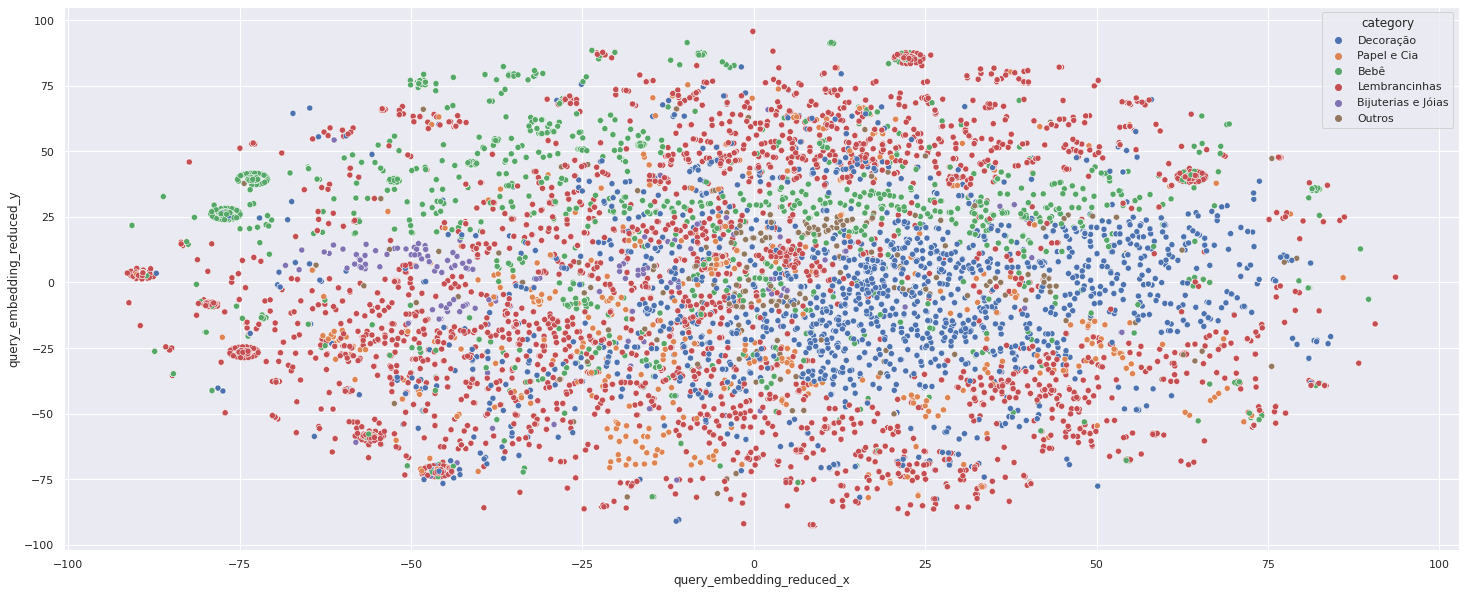

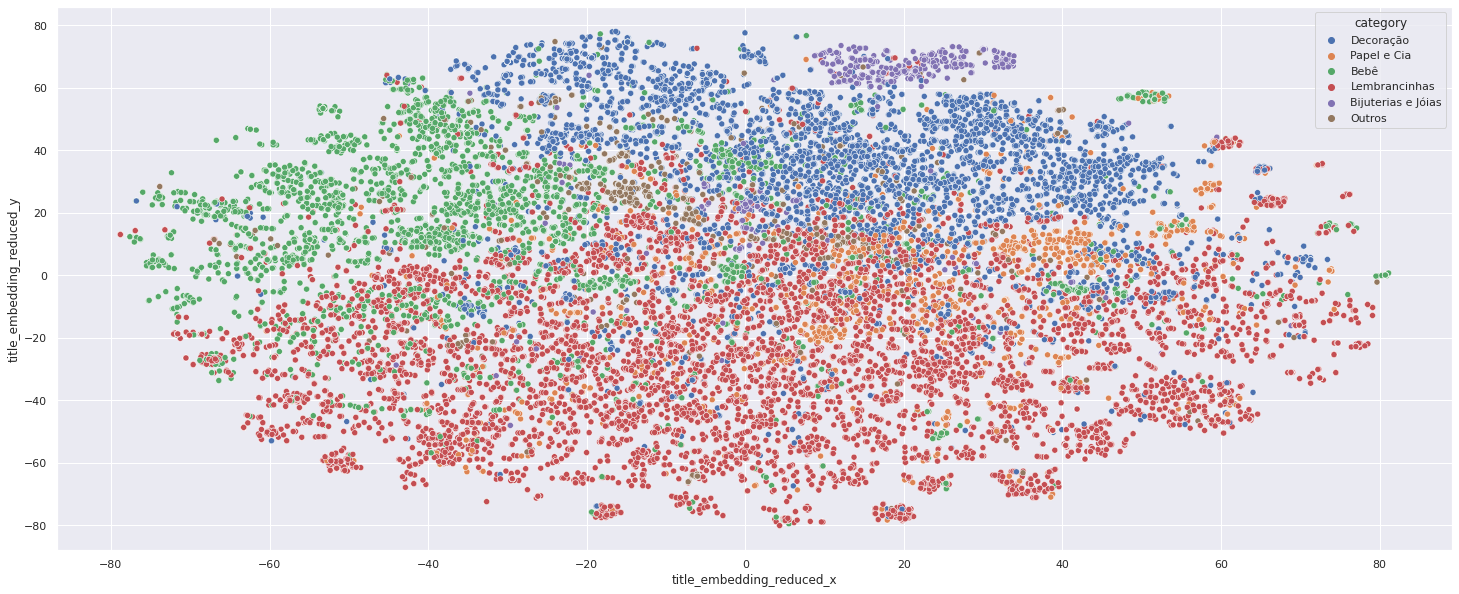

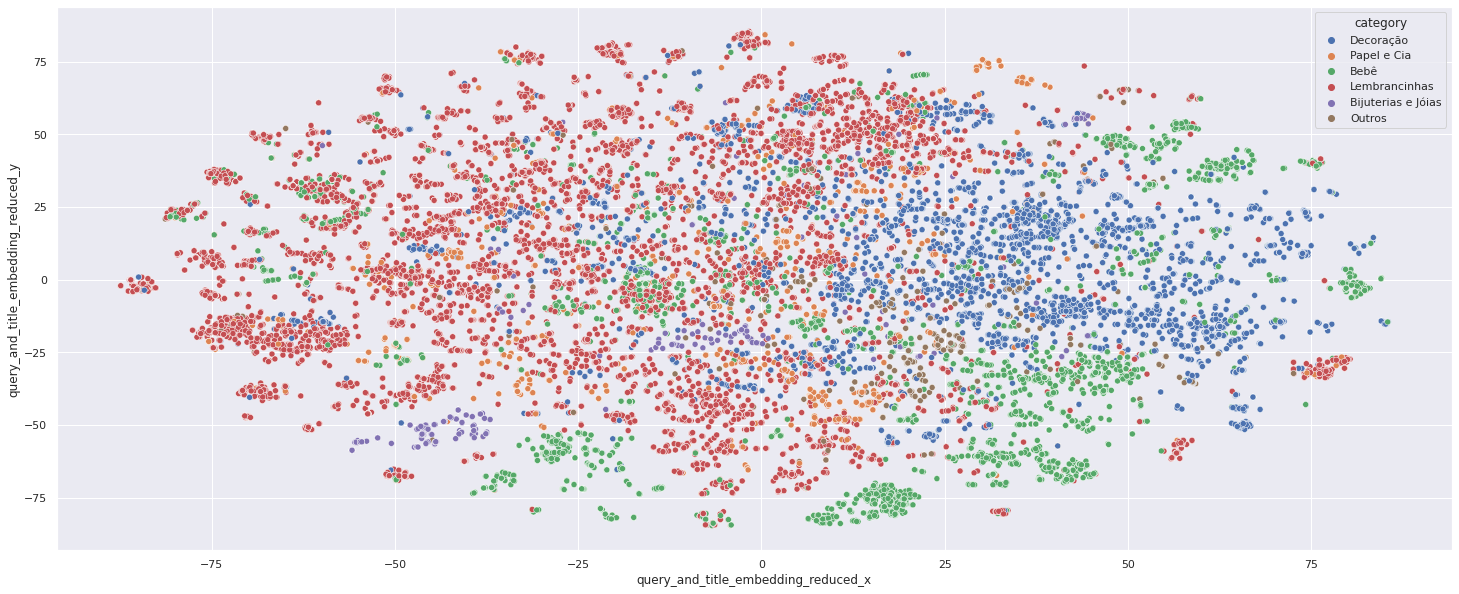

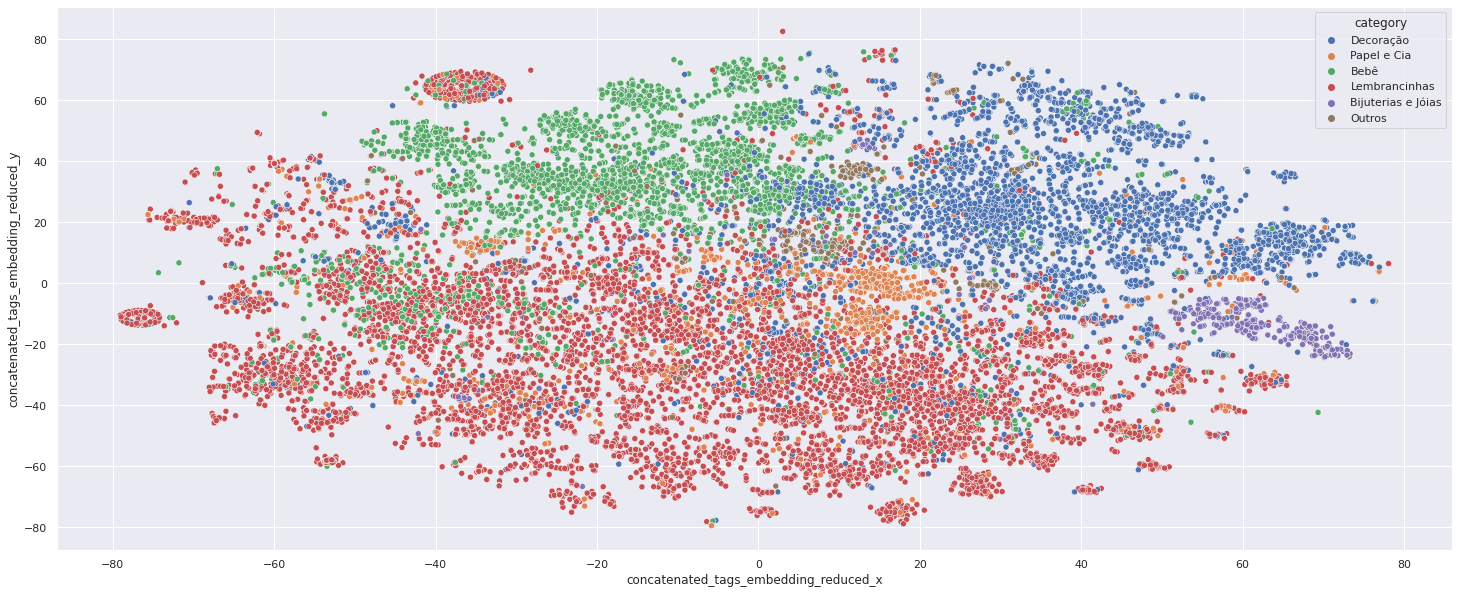

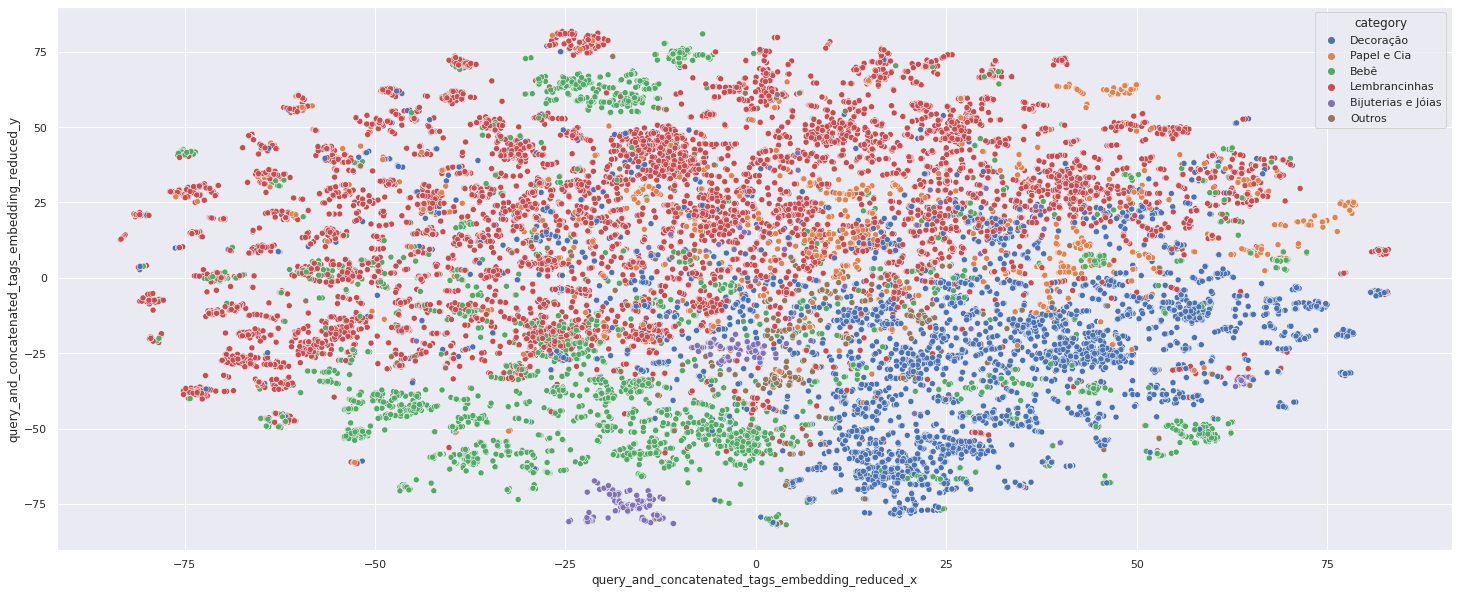

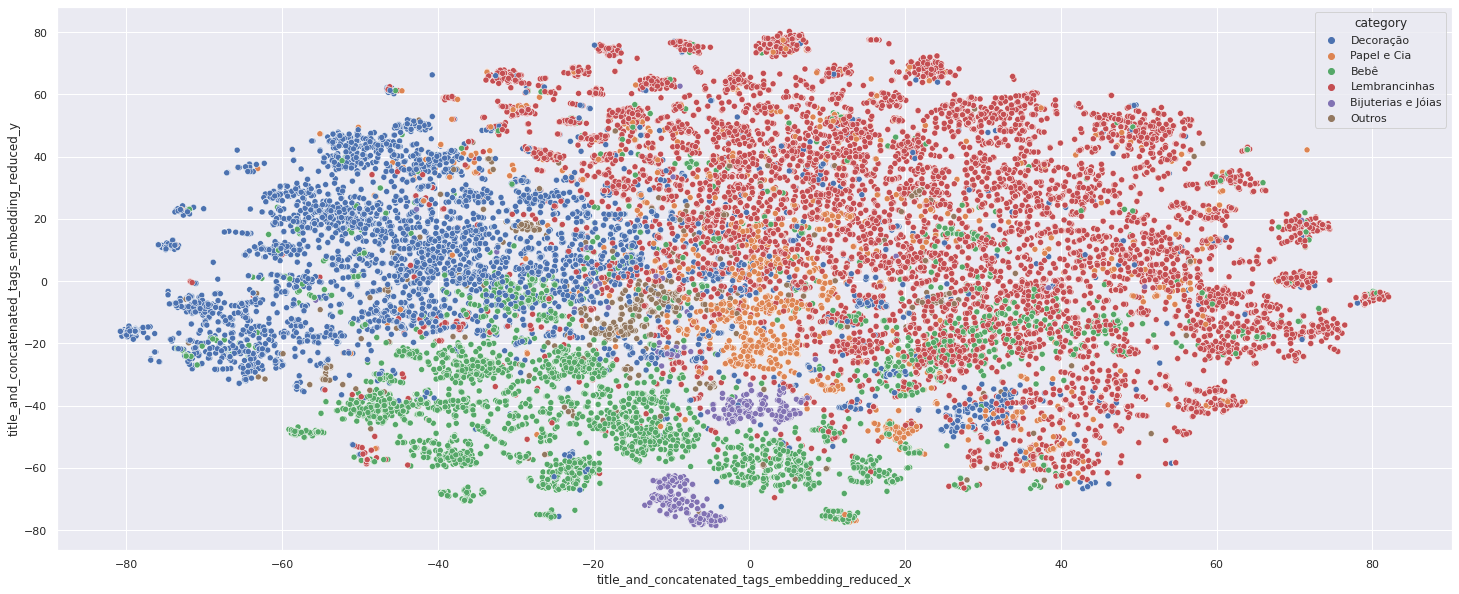

In [21]:
# Extrai a lista de colunas com embeddings criados
embeddings_columns = set([column.split('_embedding_reduced')[0]
                          for column in embeddings_frame.columns 
                          if 'embedding_reduced' in column])

# Ordena colunas extraídas por tamanho, para manter ordem de atômico para composto
embeddings_columns = sorted(embeddings_columns, key=lambda ec: len(ec))

for column in embeddings_columns:
    formatted_column = ' '.join([item.capitalize() for item in column.split('_')])
    display(HTML(f'<h3>{formatted_column}</h3>'))
    g = sns.scatterplot(x=f'{column}_embedding_reduced_x', y=f'{column}_embedding_reduced_y', data=embeddings_frame, hue="category")    
    plt.show()

Pelos gráficos, pode-se notar que *título*, *tags concatenadas* e a combinação de ambas permitem fazer agrupamento mais homogênos das categorias. Ainda há regiões em que diferentes categorias ocorrem juntas, o que pode ser pela noção de que produtos poderiam percenter a diferentes categorias, mas a utilização desses vetores pode beneficiar o modelo de classificação.

### Análise de Potencial de Predição da Similaridade

Além de poder construir vetores de características a partir do conteúdo das colunas textuais, uma possibilidade é ver o quão bem os *embeddings* conseguiriam determinar uma categoria a partir do valor da similaridade. Para isso, é possível calcular a similaridade de um determinado valor de coluna textual com o nome de cada categoria disponível. 

In [22]:
embeddings_frame.head(2)

product_id             query  search_page  position  \
0    11394449    espirito santo            2         6   
1    15534262  cartao de visita            2         0   

                    title  \
0  Mandala Espírito Santo   
1        Cartão de Visita   

                                               concatenated_tags  \
0                                                    mandala mdf   
1  cartao visita panfletos tag adesivos copos long drink canecas   

         creation_date     category  \
0  2015-11-14 19:42:12    Decoração   
1  2018-04-04 20:55:07  Papel e Cia   

                                                                                                                                         query_embedding  \
0  [0.004229284, -0.027336909, 0.030303514, 0.069929294, 0.020897388, -0.06250459, 0.050103087, -0.058517657, -0.08247556, -0.11175527, -0.06378104, ...   
1  [-0.026694268, -0.017967489, 0.033112615, 0.014724638, -0.05641233, -0.075842515, -0.024225041, -0.01875468, 0.020485003, -0.0123114195, 0.0144400...   

                                                                                                                                         title_embedding  \
0  [-0.008050227, -0.008805177, 0.05007785, 0.052670166, -0.008375991, -0.08733791, 0.08137107, -0.047023904, -0.084045015, -0.114914, -0.015285425, ...   
1  [-0.045109227, -0.025397679, 0.03495742, 0.0006268186, -0.058263194, -0.07574056, -0.011842876, -0.024876617, 0.008490498, -0.011903388, 0.0148019...   

                                                                                                                             concatenated_tags_embedding  \
0  [-0.00096480176, 0.007755412, 0.055970505, -0.0019719256, -0.019442834, -0.06424611, -0.054305594, 0.016148726, -0.004429266, -0.011865409, 0.0453...   
1  [-0.02545547, -0.014808218, 0.03331411, 0.001733836, -0.045117356, -0.026859686, -0.040624473, -0.008041078, 0.018792158, -0.03884597, 0.044826254...   

                                                                                                                                      category_embedding  \
0  [0.03335538, -0.009606168, 0.027740682, 0.013398484, -0.051526476, -0.15837763, 0.0195394, 0.046819117, 0.0717224, -0.06745236, 0.078372635, -0.06...   
1  [-0.030820217, -0.006388064, 0.005519252, 0.023567379, 0.0053899265, -0.09332599, -0.02573134, -0.018315505, -0.015907828, -0.013604142, 0.0005968...   

   query_embedding_reduced_x  query_embedding_reduced_y  \
0                 -29.673597                  10.502209   
1                 -31.401905                  -7.117732   

   title_embedding_reduced_x  title_embedding_reduced_y  \
0                 -30.202089                 -16.730453   
1                  59.451900                  28.617832   

   concatenated_tags_embedding_reduced_x  \
0                              23.232656   
1                              -8.450564   

   concatenated_tags_embedding_reduced_y  query_and_title_embedding_reduced_x  \
0                               9.564023                            -2.283381   
1                             -16.161949                             1.923607   

   query_and_title_embedding_reduced_y  \
0                            19.364161   
1                            12.850103   

   query_and_concatenated_tags_embedding_reduced_x  \
0                                       -20.086491   
1                                        42.378605   

   query_and_concatenated_tags_embedding_reduced_y  \
0                                         0.750217   
1                                        10.754856   

   title_and_concatenated_tags_embedding_reduced_x  \
0                                         3.144220   
1                                        10.136376   

   title_and_concatenated_tags_embedding_reduced_y  
0                                       -30.950533  
1                                       -34.088585

In [134]:
def compute_column_category_similarity(base_embeddings_frame: pd.DataFrame, column: str, apply_softmax: bool = False) -> pd.DataFrame:

    similarity_frame = base_embeddings_frame.copy()
    categories = base_embeddings_frame['category'].unique().tolist()
    similarity_columns = [f'similarity_{category.lower().replace(" ", "_")}' for category in categories]

    similarities_list = []
    for category in categories:
        column_embeddings = np.stack(similarity_frame[f'{selected_column}_embedding'].to_numpy(), axis=0)
        category_embedding = np.array([ft_model.get_sentence_vector(category.lower())])

        similarities_list.append(cosine_similarity(category_embedding, column_embeddings))

    if apply_softmax:
        similarity_frame[similarity_columns] = softmax(np.concatenate(similarities_list, axis=0), axis=0).T
    else:
        similarity_frame[similarity_columns] = np.concatenate(similarities_list, axis=0).T

    return similarity_frame

# Criar índices e indice invertido de posição e categoria 
category_indexes = {item:i for i, item in enumerate(embeddings_frame['category'].unique().tolist())}
inverted_category_indexes = {v:k for k, v in category_indexes.items()}

# Compor nome da coluna de similaridade para cada categoria
similarity_columns = [f'similarity_{category.lower().replace(" ", "_")}'
                          for category in embeddings_frame['category'].unique().tolist()]

predictions_by_category_name = []

for selected_column in TEXT_COLUMNS:

    # Calcular similaridades, indenficar o maior valor e o índice do maior valor de similaridade entre categorias
    similarity_frame = compute_column_category_similarity(embeddings_frame, selected_column, apply_softmax=False)
    similarity_frame = (similarity_frame
                        .assign(max_sim=lambda f: f[similarity_columns].apply(np.max, axis=1))
                        .assign(pred=lambda f: f[similarity_columns].apply(np.argmax, axis=1))
                       )

    # Formatar e apresentar resultados
    display(HTML(f'<h3><strong>{" ".join([item.capitalize() for item in selected_column.split("_")])}</strong></h3>'))
    display(similarity_frame
     [['title', selected_column, 'category', 'max_sim', 'pred'] + similarity_columns]
     .sample(10)
     .sort_values(by='max_sim', ascending=False)
    )

    # Calcular métricas de classificação multiclass usando a categoria com maior similaridade
    classification_metrics = compute_multiclass_classification_metrics(
        similarity_frame['category'].map(category_indexes),
        similarity_frame['pred']
    )
    
    # Calcular média da métricas aplicadas entre as categorias, para ter métrica global
    metrics_frame = (pd.DataFrame(classification_metrics)
                     .assign(category=lambda f: f.index.map(inverted_category_indexes))
                    )
    predictions_by_category_name.append(metrics_frame)

    display_side_by_side(
        [metrics_frame, pd.DataFrame(metrics_frame.drop(columns=['category']).mean(axis=0)).T],
        ['Métricas por Categoria', 'Média das Métricas']
    )
    

title  \
4842                         Lembrancinha Princesas   
30472       Latinhas Personalizada Festa Dinossauro   
2262                       Tag Lembrancinha 15 anos   
10389                      Copo Aniversário 50 anos   
27630                            Copo Bela e a Fera   
19487                          Caneta Personalizada   
19057           sacola de alg. cru 40x40 + silk1cor   
28780  Caixa para nove bombons com visor de acetato   
14486                               Alça chique 3cm   
22956          Orgonite Pirâmide G Pirita e Calcita   

                                   query       category   max_sim  pred  \
4842        lembrancinha festa princesas  Lembrancinhas  0.717442     3   
30472            lembrancinha dinossauro  Lembrancinhas  0.623884     3   
2262               lembrancinhas 15 anos  Lembrancinhas  0.584894     3   
10389   lembrancinha aniversario 50 anos  Lembrancinhas  0.558547     3   
27630                    a bela e a fera  Lembrancinhas  0.487270     1   
19487  caneta personalizada dia dos pais  Lembrancinhas  0.443628     5   
19057                 sacola algodao cru         Outros  0.351140     2   
28780                presente de noivado    Papel e Cia  0.346661     0   
14486                    alca para bolsa         Outros  0.339188     1   
22956                           orgonite      Decoração  0.285958     4   

       similarity_decoração  similarity_papel_e_cia  similarity_bebê  \
4842               0.558255                0.202049         0.381962   
30472              0.424180                0.220517         0.470141   
2262               0.265022                0.136081         0.275475   
10389              0.307613                0.174570         0.281538   
27630              0.191693                0.487270         0.059496   
19487              0.346309                0.384763         0.437792   
19057              0.283449                0.299843         0.351140   
28780              0.346661                0.336944         0.292392   
14486              0.282273                0.339188         0.283633   
22956              0.244861                0.090417         0.123832   

       similarity_lembrancinhas  similarity_bijuterias_e_jóias  \
4842                   0.717442                       0.317565   
30472                  0.623884                       0.212814   
2262                   0.584894                       0.294892   
10389                  0.558547                       0.180635   
27630                  0.045722                       0.343109   
19487                  0.393194                       0.291051   
19057                  0.334491                       0.308081   
28780                  0.344286                       0.331854   
14486                  0.311374                       0.322044   
22956                  0.154365                       0.285958   

       similarity_outros  
4842            0.138007  
30472           0.061610  
2262            0.258079  
10389           0.158007  
27630           0.130868  
19487           0.443628  
19057           0.093113  
28780           0.125443  
14486           0.218473  
22956           0.084531

title  \
9568                                    Lembrancinha Maternidade   
15021                        Almofada personalizada dia dos pais   
28854                                Colcha de crochê cama casal   
19862                                      Kit Tal Mae Tal Filha   
28057  Cardápio Em Pvc Personalizado Para Restaurantes Com 4 Pçs   
10886                   Borboletinhas jardim encantado Tifanny -   
8701                               PAINEL DE FESTA MASHA EO URSO   
8343                                             Jardim Vertical   
16405                                      Lápis Princesa Sophia   
28398                     Lembrança primeira eucaristia - calice   

                                                           title  \
9568                                    Lembrancinha Maternidade   
15021                        Almofada personalizada dia dos pais   
28854                                Colcha de crochê cama casal   
19862                                      Kit Tal Mae Tal Filha   
28057  Cardápio Em Pvc Personalizado Para Restaurantes Com 4 Pçs   
10886                   Borboletinhas jardim encantado Tifanny -   
8701                               PAINEL DE FESTA MASHA EO URSO   
8343                                             Jardim Vertical   
16405                                      Lápis Princesa Sophia   
28398                     Lembrança primeira eucaristia - calice   

            category   max_sim  pred  similarity_decoração  \
9568   Lembrancinhas  0.723446     3              0.490147   
15021  Lembrancinhas  0.496349     2              0.435039   
28854      Decoração  0.469806     2              0.457686   
19862           Bebê  0.434802     2              0.305911   
28057    Papel e Cia  0.410408     3              0.381765   
10886      Decoração  0.391858     4              0.371516   
8701       Decoração  0.389215     1              0.368282   
8343       Decoração  0.384207     0              0.384207   
16405  Lembrancinhas  0.364942     2              0.253978   
28398  Lembrancinhas  0.294531     3              0.275696   

       similarity_papel_e_cia  similarity_bebê  similarity_lembrancinhas  \
9568                 0.237858         0.540385                  0.723446   
15021                0.339451         0.496349                  0.411221   
28854                0.330366         0.469806                  0.310210   
19862                0.320743         0.434802                  0.323850   
28057                0.374458         0.272633                  0.410408   
10886                0.312106         0.348108                  0.362323   
8701                 0.389215         0.379399                  0.335994   
8343                 0.205370         0.306705                  0.147066   
16405                0.284121         0.364942                  0.253222   
28398                0.266155         0.212619                  0.294531   

       similarity_bijuterias_e_jóias  similarity_outros  
9568                        0.241006           0.097269  
15021                       0.277132           0.435084  
28854                       0.373661           0.154833  
19862                       0.220410           0.235142  
28057                       0.399238           0.299326  
10886                       0.391858           0.121003  
8701                        0.328134           0.120993  
8343                        0.217767           0.132962  
16405                       0.312294           0.129541  
28398                       0.171840           0.088697

title  \
24519                           Lembrancinha café com Cristo   
4382                     Copo Long Drink 350ml Personalizado   
9901                                              Touca bebê   
7139      Chaveiro Personalizado MDF - Dia dos Pais - Caneca   
462                                   Sabonete água de arroz   
25808                       Bandeirinhas balão - chá de bebê   
885                     Kit ressaca - Festa de boteco (skol)   
9996                                         Chá de lingerie   
30741  Tapete Mandala - Tapete Patchwork com Dobraduras Oval   
9359                    Capas para almofadas em barbante cru   

                                                                                                    concatenated_tags  \
24519                                                                           lembrancinha cafe cristo lembrancinha   
4382                                      lembrancinhas bento lembrancinhas copos copo long drink 350ml personalizado   
9901                                                                                                    bebe infantil   
7139                                                       caneta leticia chaveiro pais chaveiros datas comemorativas   
462    bolsas sabonete higiene relaxamento cosmeticos sabonetes artesanais funcionais arroz cristiane almeida gimenes   
25808                                                                                                        cha bebe   
885                                                niver boteco festa boteco giovanna kit ressaca caixa personalizada   
9996                                                      cha lingerie dia mulher doces cha cozinha cha bar casamento   
30741                                                         mandala tecido artesanal dobraduras tapetes passadeiras   
9359                                                                                           guarto capas almofadas   

            category   max_sim  pred  similarity_decoração  \
24519  Lembrancinhas  0.730342     3              0.453902   
4382   Lembrancinhas  0.665611     3              0.416497   
9901            Bebê  0.635021     2              0.364641   
7139   Lembrancinhas  0.565438     3              0.327812   
462           Outros  0.524955     4              0.362968   
25808           Bebê  0.519214     2              0.282449   
885    Lembrancinhas  0.505604     3              0.476640   
9996   Lembrancinhas  0.500234     0              0.500234   
30741      Decoração  0.493768     0              0.493768   
9359       Decoração  0.451374     0              0.451374   

       similarity_papel_e_cia  similarity_bebê  similarity_lembrancinhas  \
24519                0.253632         0.369391                  0.730342   
4382                 0.243591         0.386390                  0.665611   
9901                 0.253723         0.635021                  0.383526   
7139                 0.362993         0.354826                  0.565438   
462                  0.365931         0.313570                  0.413370   
25808                0.243344         0.519214                  0.355584   
885                  0.267132         0.389108                  0.505604   
9996                 0.310301         0.464853                  0.466971   
30741                0.346030         0.315515                  0.454503   
9359                 0.263649         0.334553                  0.439826   

       similarity_bijuterias_e_jóias  similarity_outros  
24519                       0.248160           0.072833  
4382                        0.367317           0.166644  
9901                        0.254181           0.136203  
7139                        0.456856           0.311179  
462                         0.524955           0.312807  
25808                       0.164031           0.059488  
885                         0.257215           0.121891  
9996                        0.3225

Pela avaliação superficial desse classificador ingênuo, título e consulta teriam um desempenho próximo, com aproximadamente 0.35 de precisão e F1, enquanto a concatenação das tags teria a eficácia maior, com 0.38 de precisão e 0.40 de F1. 

Algo recorrente que pôde ser observado no dataset é não concordância entre tags e categorias. Na tabela abaixo, é possível observar casos em que a categoria é diferente de 'Lembrancinhas', mas a única tag associada ao produto indica exatamente o conteúdo 'Lembrancinhas'. Ainda que isso seja incoerente do ponto de vista de categorização, para o vendedor faz sentido aplicar uma tag diferente da categoria para ampliar a possibilidade de seu produto casar com termos de busca de clientes.

In [114]:
(similarity_frame
 [['concatenated_tags', 'category', 'max_sim']]
 .sort_values(by='max_sim', ascending=False)
 .head()
)

concatenated_tags       category  max_sim
17623     lembrancinhas  Lembrancinhas      1.0
13979     lembrancinhas    Papel e Cia      1.0
9554      lembrancinhas           Bebê      1.0
16003     lembrancinhas  Lembrancinhas      1.0
4955      lembrancinhas           Bebê      1.0

Para tentar evitar uma dependência mais direta e essencialmente sintática entre categoria e as demais colunas textuais, a seguir é feita uma tentativa de generalização do conteúdo de cada categoria. Para isso, usa-se como embeddings da categoria não a descrição da palavra, mas a média dos embeddings dos produtos que pertencem à categoria.

In [126]:
encoded_embeddings = []
for category in embeddings_frame['category'].unique().tolist():
    for column in TEXT_COLUMNS:
        embeddings = np.stack(embeddings_frame
                              .loc[lambda f: f['category'] == category]
                              [f'{column}_embedding']
                              .to_numpy(),
                              axis=0)
        encoded_embeddings.append((category, column, np.mean(embeddings, axis=0)))        

average_embedding_frame = pd.DataFrame(encoded_embeddings, columns=['category', 'column', 'averaged_embeddings'])
display(HTML(f'<h3>Média dos Embeddings dos Registros por cada Categoria e Coluna</h3>'))
average_embedding_frame

category             column  \
0            Decoração              query   
1            Decoração              title   
2            Decoração  concatenated_tags   
3          Papel e Cia              query   
4          Papel e Cia              title   
5          Papel e Cia  concatenated_tags   
6                 Bebê              query   
7                 Bebê              title   
8                 Bebê  concatenated_tags   
9        Lembrancinhas              query   
10       Lembrancinhas              title   
11       Lembrancinhas  concatenated_tags   
12  Bijuterias e Jóias              query   
13  Bijuterias e Jóias              title   
14  Bijuterias e Jóias  concatenated_tags   
15              Outros              query   
16              Outros              title   
17              Outros  concatenated_tags   

                                                                                                                                      averaged_embeddings  
0   [-0.007964056, -0.014651332, 0.038455818, 0.01766196, -0.019800413, -0.05913129, -0.00073482434, -0.006100115, 0.012117426, -0.042138804, 0.023452...  
1   [-0.004499731, -0.011117094, 0.039307337, 0.0087564085, -0.014077116, -0.056779742, 0.000126013, -0.007247141, 0.00651129, -0.03627611, 0.01994321...  
2   [-0.003190069, -0.0072633135, 0.04421958, 0.019958705, -0.022145906, -0.05130182, -0.0014365015, -0.0067820707, 0.009300181, -0.04913421, 0.033625...  
3   [-0.018732795, -0.034160767, 0.031822205, 0.00013541491, -0.014886948, -0.06099686, -0.018668389, -0.011273392, 0.0061525726, -0.04201865, 0.01188...  
4   [-0.015145668, -0.028174656, 0.032744106, 5.9342045e-05, -0.014411121, -0.056480847, -0.015982574, -0.011586429, 0.0010866959, -0.035746813, 0.008...  
5   [-0.019253427, -0.031899285, 0.038944308, -0.0004987191, -0.022371858, -0.051442973, -0.021818992, -0.012410783, 0.0008249664, -0.04216691, 0.0213...  
6   [-0.0087795565, -0.03314465, 0.03674917, -0.014080777, -0.011695282, -0.06567188, 0.008216412, -0.014336072, 0.018310852, -0.046924997, 0.01165069...  
7   [-0.0073604425, -0.024197565, 0.036609806, -0.01523442, -0.0138698295, -0.059848763, 0.0077545196, -0.01129135, 0.00907282, -0.041313305, 0.011608...  
8   [-0.0039862837, -0.028009303, 0.03580334, -0.016909296, -0.01588895, -0.05017016, 0.007285881, -0.01181218, 0.022165973, -0.045713436, 0.02822259,...  
9   [-0.017055836, -0.03519711, 0.027647054, -0.017203981, -0.015325613, -0.04968543, -0.0066670375, -0.0145172365, 0.02349838, -0.03376357, 0.0094938...  
10  [-0.019107373, -0.032837156, 0.031193515, -0.016760847, -0.011787891, -0.051410615, -0.007494227, -0.015155565, 0.018061334, -0.035386745, 0.00935...  
11  [-0.017429171, -0.028819654, 0.032151338, -0.015874082, -0.018296452, -0.042937644, -0.005982747, -0.013096246, 0.021520954, -0.033662267, 0.02036...  
12  [-0.0038209166, -0.04604494, 0.027318906, -0.0012207765, -0.029347682, -0.052213088, 0.009443185, 0.016198652, 0.0051921885, -0.041516084, 0.02527...  
13  [-0.0015582911, -0.026164884, 0.035279237, 0.0014471235, -0.019884564, -0.05579568, 0.011767248, 0.010612631, -0.0002484724, -0.034101512, 0.02079...  
14  [0.00052918197, -0.034913577, 0.031923138, 0.0020718088, -0.032644596, -0.039635308, 0.011054089, 0.019549584, 0.00033726598, -0.037580993, 0.0277...  
15  [-0.007516479, -0.040242624, 0.034904268, -0.0035694712, -0.020783562, -0.048479754, -0.007302867, -0.0130349, 0.01363995, -0.03901185, 0.00965969...  
16  [-0.007872141, -0.02988408, 0.036828358, -0.0016022709, -0.016604465, -0.046406545, -0.0031431727, -0.011842724, 0.003404722, -0.03532482, 0.00846...  
17  [-0.006706863, -0.036492076, 0.04244292, -0.0011504192, -0.02528769, -0.036502734, -0.005838739, -0.013257201, 0.0048519433, -0.038909223, 0.01967...

In [135]:
def compute_column_category_similarity(base_embeddings_frame: pd.DataFrame, 
                                       base_categories_embeddings: pd.DataFrame, 
                                       column: str, 
                                       apply_softmax: bool = False) -> pd.DataFrame:

    similarity_frame = base_embeddings_frame.copy()
    categories = base_embeddings_frame['category'].unique().tolist()
    similarity_columns = [f'similarity_{category.lower().replace(" ", "_")}' for category in categories]

    similarities_list = []
    for category in categories:
        column_embeddings = np.stack(similarity_frame[f'{selected_column}_embedding'].to_numpy(), axis=0)
        category_embedding = (base_categories_embeddings
                              .loc[lambda f: (f['category'] == category) & (f['column'] == column)]
                              ['averaged_embeddings']
                              .iloc[0]                              
                             )
        category_embedding = np.expand_dims(category_embedding, axis=0)

        similarities_list.append(cosine_similarity(category_embedding, column_embeddings))

    if apply_softmax:
        similarity_frame[similarity_columns] = softmax(np.concatenate(similarities_list, axis=0), axis=0).T
    else:
        similarity_frame[similarity_columns] = np.concatenate(similarities_list, axis=0).T

    return similarity_frame

# Criar índices e indice invertido de posição e categoria 
category_indexes = {item:i for i, item in enumerate(embeddings_frame['category'].unique().tolist())}
inverted_category_indexes = {v:k for k, v in category_indexes.items()}

# Compor nome da coluna de similaridade para cada categoria
similarity_columns = [f'similarity_{category.lower().replace(" ", "_")}'
                          for category in embeddings_frame['category'].unique().tolist()]

predictions_by_category_content = []
for selected_column in TEXT_COLUMNS:

    # Calcular similaridades, indenficar o maior valor e o índice do maior valor de similaridade entre categorias
    similarity_frame = compute_column_category_similarity(embeddings_frame, 
                                                          average_embedding_frame,
                                                          selected_column, 
                                                          apply_softmax=False)
    similarity_frame = (similarity_frame
                        .assign(max_sim=lambda f: f[similarity_columns].apply(np.max, axis=1))
                        .assign(pred=lambda f: f[similarity_columns].apply(np.argmax, axis=1))
                       )

    # Formatar e apresentar resultados
    display(HTML(f'<h3><strong>{" ".join([item.capitalize() for item in selected_column.split("_")])}</strong></h3>'))
    display(similarity_frame
     [['title', selected_column, 'category', 'max_sim', 'pred'] + similarity_columns]
     .sample(10)
     .sort_values(by='max_sim', ascending=False)
    )

    # Calcular métricas de classificação multiclass usando a categoria com maior similaridade
    classification_metrics = compute_multiclass_classification_metrics(
        similarity_frame['category'].map(category_indexes),
        similarity_frame['pred']
    )
    
    # Calcular média da métricas aplicadas entre as categorias, para ter métrica global
    metrics_frame = (pd.DataFrame(classification_metrics)
                     .assign(category=lambda f: f.index.map(inverted_category_indexes))
                    )
    predictions_by_category_content.append(metrics_frame)
    
    display_side_by_side(
        [metrics_frame, pd.DataFrame(metrics_frame.drop(columns=['category']).mean(axis=0)).T],
        ['Métricas por Categoria', 'Média das Métricas']
    )

title  \
276    Kit Maternidade Bolsa Bebe, Mala, Mochila E Trocador 5 peças   
27518                                     lembrancinha menino coroa   
14562           Kit Saída Maternidade Menino Príncipe Personalizado   
16324                      Body Bebê Personalizado Presente de Deus   
29884                       Trio Bandejas Provençal Decoração 01-18   
16237       Almofada Personalizada -promoção 5 peças + 10 chaveiros   
10631                      Sacola Personalizada 16x20 -500 unidades   
26607                          Kit Higiene flor rosê PRONTA ENTREGA   
8479                                          Tapa fralda rosa bebê   
19181                                             Tag Personalizada   

                                        query       category   max_sim  pred  \
276                      kit mala maternidade           Bebê  0.809964     2   
27518        lembrancinhas maternidade menino  Lembrancinhas  0.801789     2   
14562                saida maternidade menino           Bebê  0.765861     2   
16324  presente personalizado para catequista           Bebê  0.712798     1   
29884                decoracao festa girassol      Decoração  0.710734     3   
16237                       almofada com foto      Decoração  0.673937     0   
10631                    sacola personalizada  Lembrancinhas  0.671155     3   
26607                             kit higiene           Bebê  0.601961     2   
8479                              tapa fralda           Bebê  0.592591     2   
19181                                     tag    Papel e Cia  0.416526     1   

       similarity_decoração  similarity_papel_e_cia  similarity_bebê  \
276                0.589356                0.669064         0.809964   
27518              0.577660                0.657997         0.801789   
14562              0.539553                0.569820         0.765861   
16324              0.600908                0.712798         0.609379   
29884              0.642354                0.643363         0.625709   
16237              0.673937                0.652461         0.631225   
10631              0.549953                0.656499         0.627473   
26607              0.491419                0.539158         0.601961   
8479               0.474307                0.446835         0.592591   
19181              0.259113                0.416526         0.291834   

       similarity_lembrancinhas  similarity_bijuterias_e_jóias  \
276                    0.669263                       0.530402   
27518                  0.765141                       0.503332   
14562                  0.620503                       0.497128   
16324                  0.708644                       0.487380   
29884                  0.710734                       0.526284   
16237                  0.619510                       0.559927   
10631                  0.671155                       0.504824   
26607                  0.526734                       0.369079   
8479                   0.499320                       0.366021   
19181                  0.333152                       0.255892   

       similarity_outros  
276             0.640855  
27518           0.607807  
14562           0.535070  
16324           0.585598  
29884           0.614593  
16237           0.667427  
10631           0.652607  
26607           0.549376  
8479            0.535823  
19181           0.314528

title  \
28676   CAPA DE CADEIRA -TECIDO OXFORD - SOFT - KIT 02 UNIDADES   
4867                            Recado de Mesa Pequeno Príncipe   
15776                    Prateleira Livro/Decoração Branco 40cm   
25052                                     Aplique bigode de Eva   
2663   Kit 2 cortinas Blackout blecaute corta luz 2,80x2,30 pvc   
20142                               LEMBRANCINHA - DIA DOS PAIS   
18174                                      Caneta Personalizada   
16237   Almofada Personalizada -promoção 5 peças + 10 chaveiros   
37                              Puff Sapateira Rústica - Yellow   
19830                                      Forminhas Dinossauro   

                                                          title  \
28676   CAPA DE CADEIRA -TECIDO OXFORD - SOFT - KIT 02 UNIDADES   
4867                            Recado de Mesa Pequeno Príncipe   
15776                    Prateleira Livro/Decoração Branco 40cm   
25052                                     Aplique bigode de Eva   
2663   Kit 2 cortinas Blackout blecaute corta luz 2,80x2,30 pvc   
20142                               LEMBRANCINHA - DIA DOS PAIS   
18174                                      Caneta Personalizada   
16237   Almofada Personalizada -promoção 5 peças + 10 chaveiros   
37                              Puff Sapateira Rústica - Yellow   
19830                                      Forminhas Dinossauro   

            category   max_sim  pred  similarity_decoração  \
28676      Decoração  0.753768     5              0.709934   
4867     Papel e Cia  0.726108     0              0.726108   
15776      Decoração  0.724385     0              0.724385   
25052  Lembrancinhas  0.724045     5              0.687987   
2663       Decoração  0.702331     0              0.702331   
20142  Lembrancinhas  0.700867     3              0.562253   
18174  Lembrancinhas  0.662502     3              0.535084   
16237      Decoração  0.652556     5              0.595016   
37         Decoração  0.605314     0              0.605314   
19830  Lembrancinhas  0.565024     3              0.513487   

       similarity_papel_e_cia  similarity_bebê  similarity_lembrancinhas  \
28676                0.695819         0.671980                  0.646296   
4867                 0.687913         0.674956                  0.679691   
15776                0.659604         0.644618                  0.640639   
25052                0.634968         0.637529                  0.636085   
2663                 0.627769         0.645243                  0.599591   
20142                0.664568         0.612088                  0.700867   
18174                0.650444         0.572633                  0.662502   
16237                0.632350         0.592889                  0.630642   
37                   0.533499         0.503677                  0.526630   
19830                0.532005         0.510781                  0.565024   

       similarity_bijuterias_e_jóias  similarity_outros  
28676                       0.630464           0.753768  
4867                        0.633785           0.663660  
15776                       0.581363           0.687837  
25052                       0.634290           0.724045  
2663                        0.579744           0.691392  
20142                       0.489594           0.562949  
18174                       0.507591           0.581503  
16237                       0.574290           0.652556  
37                          0.487713           0.593310  
19830                       0.428648           0.537772

title  \
30049                                    Tapete de croche   
30790                   Kit Bolsa Maternidade com 2 peças   
25536                 Lembrancinha de aniversario 80 anos   
26409       Bancos rústico madeira Curió c/ mesa acoplada   
3540                            Enfeite Porta Maternidade   
26111          Aplique para tubete 13cm Poderoso chefinho   
6268   Bolsa maternidade personalizada 5 pçs azul marinho   
10875        Pen Drive Giratório 30 pçs Personalizado 4gb   
19917                                 Caneca Dia dos Pais   
22391                    Digital: Cardápio/Catálogo Doces   

                                                                         concatenated_tags  \
30049                                          tapete tapetes decoracao casa tapete croche   
30790       bolsas bolsas maternidade bolsa maternidade kit bolsas maternidade menino bebe   
25536                                     fadas lembrancinhas lembrancinhas aniversario 70   
26409  area externa rustica cadeira cjto mesa banco varanda mesa bancos poltronas cadeiras   
3540                                           porta maternidade enfeite porta maternidade   
26111                                  apliques tubete poderoso chefinho apliques recortes   
6268                                                                kit bolsa 5 pcs menino   
10875                                                     pen drives embalagens fotografia   
19917                                                                             dia pais   
22391                                                             bares/restaurantes afins   

            category   max_sim  pred  similarity_decoração  \
30049      Decoração  0.815818     0              0.815818   
30790           Bebê  0.811460     2              0.629608   
25536  Lembrancinhas  0.791845     3              0.589160   
26409      Decoração  0.724317     0              0.724317   
3540            Bebê  0.704496     2              0.632162   
26111  Lembrancinhas  0.699415     5              0.661706   
6268            Bebê  0.671600     2              0.552813   
10875  Lembrancinhas  0.635520     1              0.552682   
19917  Lembrancinhas  0.580494     3              0.456499   
22391    Papel e Cia  0.463044     5              0.437198   

       similarity_papel_e_cia  similarity_bebê  similarity_lembrancinhas  \
30049                0.608619         0.662429                  0.608473   
30790                0.658431         0.811460                  0.673342   
25536                0.697723         0.626251                  0.791845   
26409                0.561420         0.567530                  0.532428   
3540                 0.581921         0.704496                  0.609181   
26111                0.672486         0.614492                  0.634535   
6268                 0.602180         0.671600                  0.622445   
10875                0.635520         0.471091                  0.520204   
19917                0.552209         0.507104                  0.580494   
22391                0.441083         0.354624                  0.380065   

       similarity_bijuterias_e_jóias  similarity_outros  
30049                       0.538792           0.727752  
30790                       0.585362           0.694381  
25536                       0.532624           0.620706  
26409                       0.506772           0.622547  
3540                        0.517163           0.587709  
26111                       0.555831           0.699415  
6268                        0.507798           0.620050  
10875                       0.479910           0.600176  
19917                       0.373631           0.440508  
22391                       0.389844           0.463044

Com a troca da análise de similaridade pelo conteúdo dos itens da categoria em vez do simples nome da categoria, houve um aumento significativo da eficácia. 

In [140]:
metrics_by_category_name = pd.concat(predictions_by_category_name, axis=0)
metrics_by_category_content = pd.concat(predictions_by_category_content, axis=0)

display_side_by_side([metrics_by_category_name, metrics_by_category_content], ['Name', 'Content'])